# Post-processing of climate calibration

In [1]:
import numpy as np
import pandas as pd
from mce.core.forcing import RfCO2
from mce.core.climate import IrmBase
import matplotlib as mpl
from mce.util.plot_base import PlotBase

In [2]:
# Normalized CMIP data
with pd.HDFStore('data/cmip_normalized.h5', 'r') as store:
    df_norm_cmip5 = store['CMIP5/climate_norm1']
    df_norm_cmip6 = store['CMIP6/climate_norm1']

In [3]:
# Calibration results
outpath = 'data/parms_calib_climate.h5'
with pd.HDFStore(outpath, 'r') as store:
    df_parms = store['cmip_norm1__nl3']

## Emulation example

In [4]:
class Driver:
    def __init__(self):
        self.forcing = RfCO2()
        self.climate = IrmBase()

    def parms_update(self, parms):
        self.forcing.parms.update(
            alpha=parms['co2_alpha'],
            beta=parms['co2_beta'],
        )
        self.climate.parms.update(
            asj=parms[['a0', 'a1', 'a2']].values,
            tauj=parms[['tau0', 'tau1', 'tau2']].values,
            lamb=parms['lambda'],
        )

    def run(self, time_4x, time_1p, parms):
        self.parms_update(parms)

        df_irm = {}

        # 4xCO2 forcing
        q4x = self.forcing.x2erf(4.)

        d1 = self.climate.response_ideal(
            time_4x, kind='step', variable='flux',
        )
        df_irm['abrupt-4xCO2'] = pd.DataFrame({
            'tas': (1. - d1) * q4x / parms['lambda'],
            'rtnt': d1 * q4x,
        }, index=time)

        # 1pctCO2 forcing
        q1p = self.forcing.x2erf(1.01 ** time_1p)
        d1 = self.climate.response(time_1p, q1p)
        df_irm['1pctCO2'] = pd.DataFrame({
            'rtnt': q1p - q1p / parms['lambda'],
            'tas': d1,
        }, index=time_1p)

        return pd.concat(df_irm, axis=1).T

In [5]:
driver = Driver()

In [6]:
# Time points have initial 0 and subsequent mid points
# with spacing of 1 year during the first 150 years,
# and additional year 3000 as an asymptotic equilibrium state for abrupt-4xCO2
time = np.hstack([
    0., 
    np.arange(150) + 0.5,
    3000.,
])

In [7]:
# Emulator runs with calibration for a specific GCM
source_id = 'MIROC-ES2L'
parms = df_parms.loc[('CMIP6', source_id)]
df_irm = driver.run(time, time[:141], parms)

In [8]:
df_irm

0.0       0.5       1.5       2.5       3.5     \
abrupt-4xCO2 tas   1.210604e-15  0.780875  1.620335  2.026315  2.267501   
             rtnt  7.846239e+00  6.722460  5.514368  4.930110  4.583013   
1pctCO2      rtnt  0.000000e+00  0.007705  0.023115  0.038525  0.053935   
             tas   0.000000e+00  0.001351  0.009439  0.021310  0.035181   

                     4.5       5.5       6.5       7.5       8.5     ...  \
abrupt-4xCO2 tas   2.440739  2.581468  2.703134  2.811256  2.908456  ...   
             rtnt  4.333701  4.131174  3.956081  3.800480  3.660596  ...   
1pctCO2      rtnt  0.069344  0.084754  0.100164  0.115574  0.130984  ...   
             tas   0.050357  0.066532  0.083547  0.101300  0.119713  ...   

                    141.5     142.5     143.5     144.5     145.5     146.5   \
abrupt-4xCO2 tas   4.12858  4.130883  4.133183  4.135478  4.137769  4.140057   
             rtnt  1.90468  1.901365  1.898056  1.894753  1.891455  1.888164   
1pctCO2      rtnt      NaN       NaN       NaN       NaN       NaN       NaN   
             tas       NaN       NaN       NaN       NaN       NaN       NaN   

                     147.5     148.5     149.5     3000.0  
abrupt-4xCO2 tas   4.142340  4.144619  4.146895  5.442967  
             rtnt  1.884878  1.881597  1.878323  0.013108  
1pctCO2      rtnt       NaN       NaN       NaN       NaN  
             tas        NaN       NaN       NaN       NaN  

[4 rows x 152 columns]

In [9]:
# Reference GCM data
df_gcm = df_norm_cmip6.loc[source_id]

In [10]:
df_gcm

0.5       1.5       2.5       3.5       4.5       5.5    \
1pctCO2      rtnt  0.129188 -0.585808 -0.008943  0.361227  0.194247  0.056531   
             tas  -0.045316  0.056799 -0.131145 -0.110644 -0.016221 -0.021734   
abrupt-4xCO2 rtnt  6.796204  5.933772  4.092336  4.512156  4.625064  4.247051   
             tas   0.868674  1.666433  2.116636  2.086519  2.243489  2.582014   
piControl    rtnt  0.059101 -0.347125  0.009049  0.182584  0.014600 -0.305182   
             tas  -0.037194  0.123404 -0.113995 -0.110481  0.062888  0.112110   

                      6.5       7.5       8.5       9.5    ...  357.5  358.5  \
1pctCO2      rtnt  0.178786 -0.420821  0.462706  0.720697  ...    NaN    NaN   
             tas   0.125737  0.168304 -0.102042 -0.113731  ...    NaN    NaN   
abrupt-4xCO2 rtnt  3.413594  2.705752  4.029186  3.860165  ...    NaN    NaN   
             tas   2.968372  2.947448  2.659773  2.798532  ...    NaN    NaN   
piControl    rtnt -0.097378  0.520204 -0.077017  0.000205  ...    NaN    NaN   
             tas  -0.092496 -0.189670 -0.062300 -0.075531  ...    NaN    NaN   

                   359.5  360.5  361.5  362.5  363.5  364.5  365.5  366.5  
1pctCO2      rtnt    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
             tas     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
abrupt-4xCO2 rtnt    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
             tas     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
piControl    rtnt    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
             tas     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[6 rows x 367 columns]

In [11]:
# Plot module
myplt = PlotBase(palette='ipcc_wg1')

In [12]:
# Color setting
def mk_darker(color_hex):
    sca = np.array([1., 1., 0.7])
    return mpl.colors.to_hex(mpl.colors.hsv_to_rgb(
        mpl.colors.rgb_to_hsv(mpl.colors.to_rgb(color_hex)) * sca
    ))

colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
color_4x = colors[2]
color_1p = colors[1]
color_4x_dark = mk_darker(colors[2])
color_1p_dark = mk_darker(colors[1])

In [13]:
# Other plot setting
map_name_unit = {
    'rtnt': '{} ({})'.format('TOA net radiation', 'Wm$^{−2}$'),
    'tas': '{} ({})'.format('Temperature change', '°C'),
}

ls_gcm = {
    'ls': 'None', 'mfc': 'none', 'ms': 4, 'mew': 0.6, 'alpha': 0.8,
}
map_ls = {
    ('GCM', 'abrupt-4xCO2'): {'color': color_4x, 'marker': 's', **ls_gcm},
    ('GCM', '1pctCO2'): {'color': color_1p, 'marker': '^', **ls_gcm},
    ('IRM', 'abrupt-4xCO2'): {'color': color_4x_dark, 'lw': 1.5},
    ('IRM', '1pctCO2'): {'color': color_1p_dark, 'lw': 1.5},
    'TCR GCM': { # 20-yr mean in years 60 to 79
        'color': color_1p, 'lw': 1.5,
    },
    'TCR IRM': {
        'ls': 'None', 'mfc': 'w', 'mec': color_1p_dark, 'ms': 5,
        'mew': 1., 'marker': 'o',
    },
}

In [18]:
map_ls[('GCM', experiment_id)]

{'color': '#c47900',
 'marker': 's',
 'ls': 'None',
 'mfc': 'none',
 'ms': 4,
 'mew': 0.6,
 'alpha': 0.8}

<Axes: >

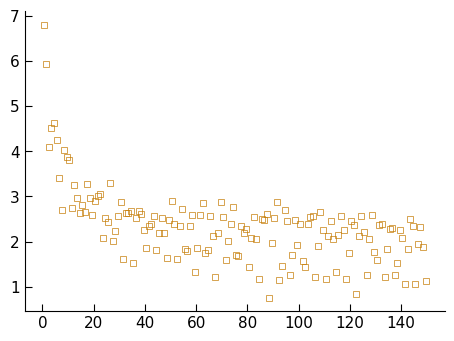

In [23]:
myplt.init_general()
ax = myplt(0)
df_gcm.loc[(experiment_id, variable_id)].dropna().plot(
    ax=ax, **map_ls[('GCM', experiment_id)],
)

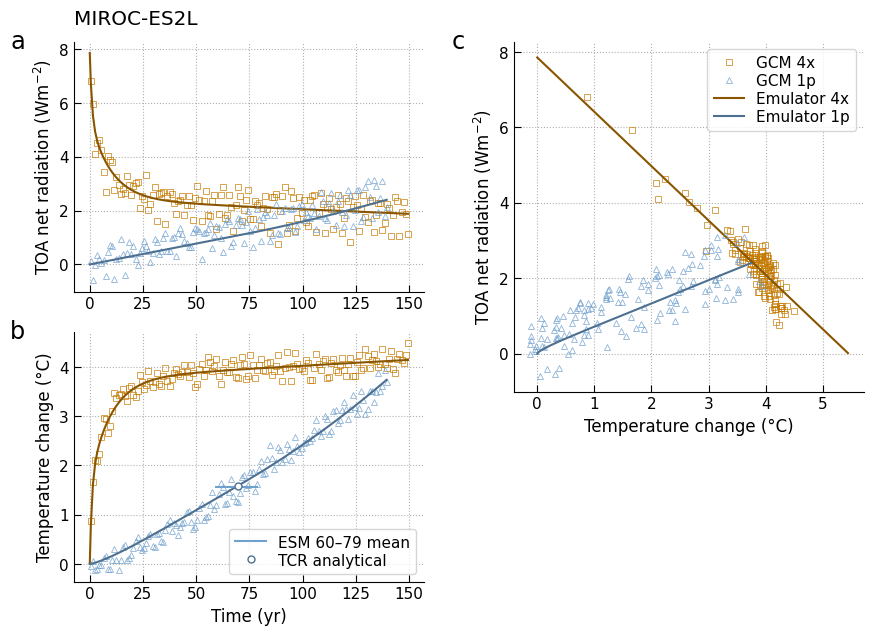

In [27]:
height = 2.5
aspect = 1.4
wspace = 0.9
hspace = 0.4
kw1 = {
    'height': height*aspect, 'aspect': 1.,
    'yoff': height*2 + hspace - height*aspect,
}
myplt.init_general(
    height=height, aspect=aspect, wspace=wspace, hspace=hspace,
    extend=[('bottom', -1, {}), ('right', -1, kw1)],
)

for n, variable_id in enumerate(['rtnt', 'tas']):
    ax = myplt(n)

    for experiment_id in ['abrupt-4xCO2', '1pctCO2']:
        d1 = df_gcm.loc[(experiment_id, variable_id)].dropna()
        ax.plot(d1.index, d1, **map_ls[('GCM', experiment_id)])
        d1 = df_irm.loc[(experiment_id, variable_id)].loc[:151].dropna()
        ax.plot(d1.index, d1, **map_ls[('IRM', experiment_id)])

    ax.set_ylabel(map_name_unit[variable_id])
    if n == 1:
        ax.set_xlabel('Time (yr)')

    ax.grid()


ax.hlines(parms['tcr_gcm'], 59., 79., **map_ls['TCR GCM'])
tp_2x = np.log(2) / np.log(1.01)
ax.plot(tp_2x, parms['tcr'], **map_ls['TCR IRM'])

handles = [
    mpl.lines.Line2D([0], [0], **map_ls['TCR GCM']),
    mpl.lines.Line2D([0], [0], **map_ls['TCR IRM']),
]
labels = ['ESM 60–79 mean', 'TCR analytical']
ax.legend(handles, labels, labelspacing=0.2)

ax = myplt(2)

for experiment_id in ['abrupt-4xCO2', '1pctCO2']:
    ax.plot(
        df_gcm.loc[(experiment_id, 'tas')].dropna().values,
        df_gcm.loc[(experiment_id, 'rtnt')].dropna().values,
        **map_ls[('GCM', experiment_id)],
    )
    ax.plot(
        df_irm.loc[(experiment_id, 'tas')].dropna().values,
        df_irm.loc[(experiment_id, 'rtnt')].dropna().values,
        **map_ls[('IRM', experiment_id)],
    )
    ax.set_xlabel(map_name_unit['tas'])
    ax.set_ylabel(map_name_unit['rtnt'])

ax.grid()

handles = [
    mpl.lines.Line2D([0], [0], **map_ls[('GCM', 'abrupt-4xCO2')]),
    mpl.lines.Line2D([0], [0], **map_ls[('GCM', '1pctCO2')]),
    mpl.lines.Line2D([0], [0], **map_ls[('IRM', 'abrupt-4xCO2')]),
    mpl.lines.Line2D([0], [0], **map_ls[('IRM', '1pctCO2')]),
]
labels = ['GCM 4x', 'GCM 1p', 'Emulator 4x', 'Emulator 1p']
ax.legend(handles, labels, labelspacing=0.2)

myplt.panel_label(
    xy=(0., 1.), xytext=(-35, 0),
    ha='right', va='center',
)

pos = myplt.get_fig_position_relto_axes((0, 1))
_ = myplt.figure.text(
    pos[0], pos[1] + 0.02, source_id,
    ha='left', va='bottom', size='large',
)